In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import numpy as np
import neurospyke as ns
import h5py
from scipy.signal import find_peaks, savgol_filter, butter, lfilter
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
sampling_frequency = 25000 # 25 kHz
sampling_time = 1/sampling_frequency
signal_duration = 5 * 30 + 5
f = h5py.File('./data/ET1/R21-15/PostLesion_Mapping/Raw_P1_Ch_003.mat')

data = f['data'][:]
data = np.reshape(data, np.size(data))
data = data[np.arange(0, signal_duration * sampling_frequency)]
raw_data = np.copy(data)

Idea per SALPA:
- anziché usare il find_peaks, sfruttare la conoscenza del pattern di stimolazione, creare una finestra attorno alla posizione presunta di ogni picco e beccare il valore massimo (negativo, visto che i picchi partono da giù). Quello sarà assunto come loc del picco
- alla fine del SALPA eseguire un find_peaks con threshold molto alta per togliere eventuali stimolazioni sbagliate e riapplicare in maniera iterativa il SALPA

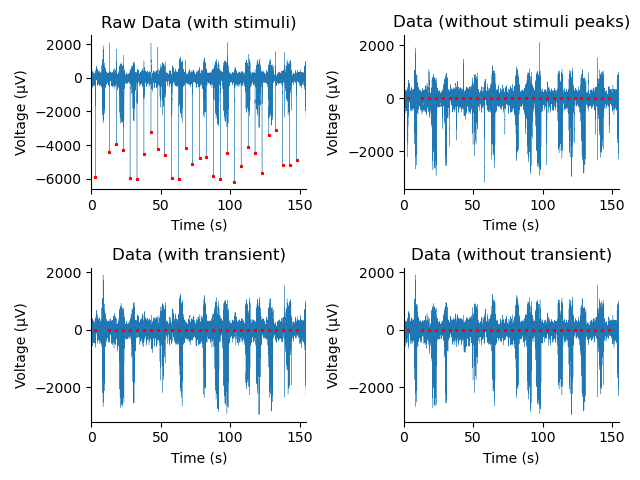

In [66]:
# SALPA execution
# Comment the line below to execute an extra SALPA round on the data in order to remove extra peaks
data = np.copy(raw_data)
_, ax = plt.subplots(2, 2)

stimulus_idxs, _ = find_peaks(abs(data), height=3000, distance=4 * sampling_frequency)

ns.visualization.plot_spikes(data, stimulus_idxs, ax=ax[0][0], sampling_time=sampling_time, title='Raw Data (with stimuli)')

stimulus_samples = 100 # samples
stimulus_half_samples = int(np.ceil(stimulus_samples / 2))
stimulus_range = np.arange(-stimulus_half_samples, stimulus_half_samples)

transient_duration = 0.7 # seconds
transient_samples = int(np.ceil(transient_duration * sampling_frequency))
transient_range = np.arange(stimulus_half_samples, stimulus_half_samples + transient_samples)
transients = []

for stimulus_idx in stimulus_idxs:
    data[stimulus_idx + stimulus_range] = 0
    transients.append(data[stimulus_idx + transient_range])

ns.visualization.plot_spikes(data, stimulus_idxs, ax=ax[0][1], sampling_time=sampling_time, title='Data (without stimuli peaks)')

mean_transient = np.mean(transients, 0)
# ns.visualization.plot_raw_data(mean_transient)

zero_idx = np.where(mean_transient >= 0)[0][0]
extended_stimulus_range = np.arange(stimulus_half_samples, stimulus_half_samples + zero_idx)
transients = []

for stimulus_idx in stimulus_idxs:
    data[stimulus_idx + extended_stimulus_range] = 0
    transients.append(data[stimulus_idx + transient_range])

ns.visualization.plot_spikes(data, stimulus_idxs, ax=ax[1][0], sampling_time=sampling_time, title='Data (with transient)')

mean_transient = np.mean(transients, 0)
mean_transient_smoothed = savgol_filter(mean_transient, 2001, 2)
# ns.visualization.plot_raw_data(mean_transient)

for stimulus_idx in stimulus_idxs:
    data[stimulus_idx + transient_range] = data[stimulus_idx + transient_range] - mean_transient_smoothed

ns.visualization.plot_spikes(data, stimulus_idxs, ax=ax[1][1], sampling_time=sampling_time, title='Data (without transient)')

plt.tight_layout()

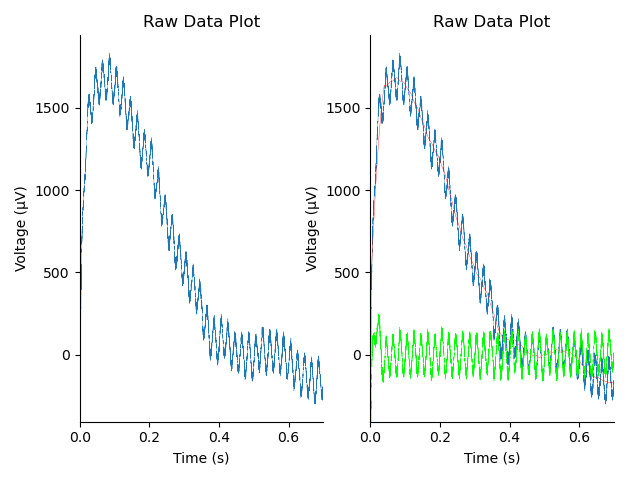

In [58]:
# Check SALPA transient
_, ax = plt.subplots(1, 2)

transient_std = np.std(transients, 0)
ax[0].fill_between(transient_range * sampling_time, mean_transient - transient_std, mean_transient + transient_std, alpha=0.25)
ns.visualization.plot_raw_data(mean_transient, ax=ax[0], sampling_time=sampling_time)
plt.tight_layout()

ns.visualization.plot_raw_data(mean_transient, ax=ax[1], sampling_time=sampling_time)
ns.visualization.plot_raw_data(mean_transient_smoothed, ax=ax[1], sampling_time=sampling_time, color='#FF0000')
ns.visualization.plot_raw_data(mean_transient - mean_transient_smoothed, ax=ax[1], sampling_time=sampling_time, color='#00FF00')

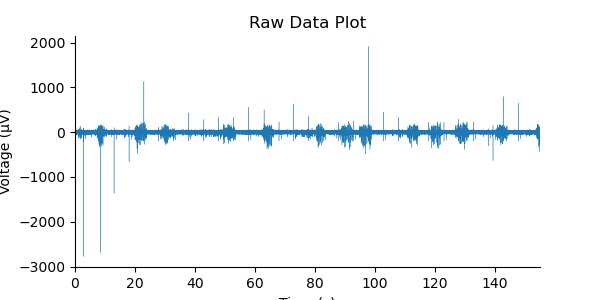

In [63]:
num, den = butter(1, [300, 7000], btype='bandpass', fs=sampling_frequency)
filtered_data = lfilter(num, den, data)

ns.visualization.plot_raw_data(filtered_data, sampling_time=sampling_time)

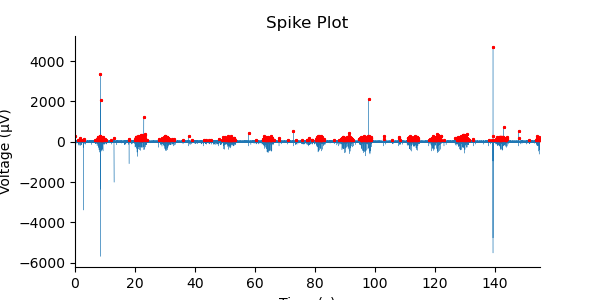

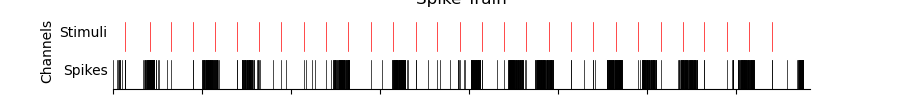

In [33]:
from scipy.stats import median_abs_deviation
threshold = 4*1.4824*median_abs_deviation(filtered_data)
spikes_idxs, _ = ns.spikes.hard_threshold_local_maxima(filtered_data, threshold, 0.003, use_abs=False, sampling_time=sampling_time)

ns.visualization.plot_spikes(filtered_data, spikes_idxs, sampling_time=sampling_time)
ns.visualization.plot_spike_train([spikes_idxs, stimulus_idxs], channel_labels=['Spikes', 'Stimuli'], color=['#000000', '#FF0000'], sampling_time=sampling_time, figsize=(9, 1), dpi=100)
